In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def deriv_forest(x, y, penalty_rate, args):
    fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old = args
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y
    return dx, dy
    

fertility = 4.2
# mortality_young = 0.01 # should be the weird quadratic function but i think making a constant based on data is better
# for now implemented as 
aging_rate = 1
biotic_pump_young = 0.3
mortality_old = 2
biotic_pump_old = 0.1

arguments = (fertility, mortality_young, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old)

penalty_rate_1 = 0.5 # Will need penalty function call over # Will need penalty function call
x_1 = 1
y_1 = 2
dx, dy = deriv_forest(x_1, y_1, penalty_rate_1, arguments)
print(dx, dy)

x_2 = 2
y_2 = 1
penalty_rate_2 = 0.6 # Penalty function call over x1, y1



5.550000000000001 -2.9


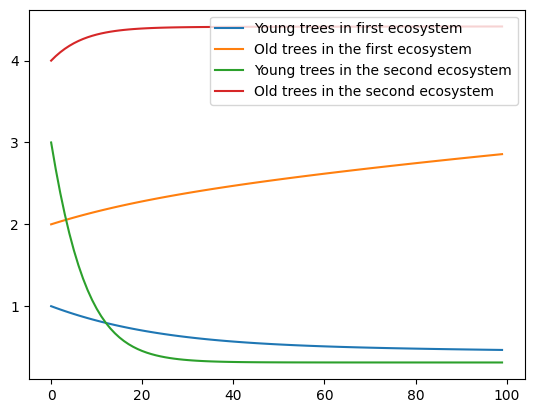

In [60]:
def system_two_forests(x_1, y_1, x_2, y_2, args, timesteps = 100):
    """
    x_1 = initial value for the young trees in the first ecosystem 
    y_1 = initial value for the old trees in the first ecosystem
    x_1 = initial value for the young trees in the second ecosystem 
    y_1 = initial value for the old trees in the second ecosystem
    
    """
    
    dt = 0.01 # possible to edit
    young_forest_1 = []
    old_forest_1 = []
    young_forest_2 = []
    old_forest_2 = []
    # function call of penalty function
    penalty_rate_1 = -0.5 # Will need penalty function call 
    penalty_rate_2 = -0.6 # Will need penalty function call
    
    for i in range(timesteps):
        # penalty rate function call
        young_forest_1.append(x_1)
        old_forest_1.append(y_1)
        young_forest_2.append(x_2)
        old_forest_2.append(y_2)
        dx_1, dy_1 = deriv_forest(x_1, y_1, penalty_rate_1, args)
        dx_2, dy_2 = deriv_forest(x_2, y_2, penalty_rate_2, args)

        # Update values using forward Euler
        x_1 += dx_1 * dt
        y_1 += dy_1 * dt
        x_2 += dx_2 * dt
        y_2 += dy_2 * dt
    
    return young_forest_1, old_forest_1, young_forest_2, old_forest_2

time = 100
young_1, old_1, young_2, old_2 = system_two_forests(1, 2, 3, 4, args, time)
plt.plot(range(100), young_1, label ="Young trees in first ecosystem")
plt.plot(range(100), old_1, label = "Old trees in the first ecosystem")
plt.plot(range(100), young_2, label = "Young trees in the second ecosystem")
plt.plot(range(100), old_2, label = "Old trees in the second ecosystem")
plt.legend()
plt.show()